# Imports

In [1]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
from scipy.interpolate import splrep, BSpline # for Spline graphs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
plt.rcParams["font.family"] = "Times New Roman"
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'zscore_score',
   'zscore_round_duration',
   'zscore_efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   'ort_img',
   'rep_man',
   'soc_pers',
   'team_size',
   'difficulty',
   'score',
   'duration',
   'efficiency',
   'timestamp']},
 'dat': {'filename': 'DAT_output_conversation_level.csv',
  'cols_to_ignore':

# Per-Task Splines
This notebook contains univariate spline models to show how different independent variables relate to the dependent variable(s) of interest, for each task.


# Jury

### Full Data (100)%

In [3]:
# Define the basic model
juries_model = ModelBuilder(dataset_names = ["juries"])
juries_model.select_target(target=["majority_pct"])
juries_model.define_model(model_type = 'rf')

In [4]:
# this is the conversation data for the juries
juries_model.conv

,average_positive_bert,stdev_positive_bert,min_positive_bert,max_positive_bert,average_negative_bert,average_num_words,average_num_chars,average_info_exchange_zscore_chats,min_info_exchange_zscore_conversation,average_discrepancies,...,average_user_num_chars,stdev_user_num_chars,min_user_num_chars,max_user_num_chars,average_user_function_word_accommodation,min_user_function_word_accommodation,max_user_function_word_accommodation,within_person_disc_range,target_raw,target_std
0,0.646356,0.717879,0.469979,0.245807,-0.043844,0.607308,0.476453,0.584580,0.521946,-0.290319,...,0.924751,-0.263030,-0.085796,-0.116403,0.484640,0.104664,0.536814,-0.080683,1.000000,0.975118
1,-0.293294,-0.180408,-0.412163,0.290992,0.353607,0.131589,0.197560,0.115462,0.475637,0.604697,...,1.304328,-0.515565,2.258496,0.746405,0.310409,1.242884,-0.580860,-2.581959,0.600000,-1.368196
2,-0.796815,-1.015673,0.719373,-1.376046,1.218315,-0.935586,-0.875968,-0.905195,0.065848,-1.041182,...,-0.880933,-0.672529,-0.639048,-0.630211,-1.322390,-1.033556,-1.379199,-0.376677,0.666667,-0.977643
3,-0.422633,-0.549036,-0.517383,-0.068313,-0.569256,-1.003303,-0.969518,-0.991655,-0.614729,-0.034870,...,0.071355,0.414792,-0.657803,0.193820,-1.417968,-1.033556,-1.379199,-0.485633,0.750000,-0.489453
4,0.125517,0.797358,-0.149221,0.958074,-0.802791,-0.097125,-0.115733,-0.120649,0.642710,0.334111,...,2.255442,-0.697880,3.289984,0.896670,1.760015,2.001697,0.217479,0.213272,1.000000,0.975118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,0.783603,0.119937,1.492585,0.092300,-0.788423,-1.056287,-1.060300,-1.078115,0.757012,-1.616218,...,-1.437788,-0.460387,-1.736177,-1.289435,-0.637411,-1.033556,-0.740528,1.328013,1.000000,0.975118
344,3.664821,1.721237,1.069400,0.919969,-2.642732,-2.259720,-2.275819,-2.306169,2.023648,-1.603040,...,-0.702176,-0.612884,-0.460882,-0.935587,-1.999404,-1.033556,-2.017870,-0.671452,0.800000,-0.196539
345,3.446339,1.929767,0.145186,0.931435,-2.417840,-2.362548,-2.295926,-2.346385,1.557210,-1.901480,...,-0.542378,0.584858,-0.789083,-0.286057,-1.959580,-1.033556,-2.177538,-1.058152,1.000000,0.975118
346,0.594014,0.695029,0.292817,0.881477,-0.092745,-1.195845,-1.159020,-1.216522,1.297698,-0.854828,...,0.045128,-0.694042,0.392440,-0.198806,-0.711750,-0.274743,-0.900196,-1.274432,1.000000,0.975118


In [5]:
sns.set_context("paper", rc={"axes.labelsize":20})
sns.set_context("talk", font_scale=1.4)

def plot_single_linear_model(conversation_data, x_vars, y_vars, num_top_plots=None):
    num_plots = len(x_vars) * len(y_vars)
    num_rows = len(y_vars)
    num_cols = len(x_vars)
    num_plots_per_row = min(5, num_cols)

    num_rows_needed = math.ceil(num_plots / num_plots_per_row)
    fig_height = num_rows_needed * 5
    fig_width = num_plots_per_row * 5

    plt.figure(figsize=(fig_width, fig_height))
    
    plot_num = 1
    metrics_values = []
    
    if num_top_plots is not None:
        all_metrics = []

    for y_var in y_vars:
        for x_var in x_vars:
            if num_top_plots is not None:
                x_data = conversation_data[x_var].values.reshape(-1, 1)
                y_data = conversation_data[y_var].values

                # Fit linear regression model
                model = LinearRegression()
                model.fit(x_data, y_data)

                # Predict using the model
                y_pred = model.predict(x_data)

                # Calculate metrics
                r_squared = r2_score(y_data, y_pred)
                mse = mean_squared_error(y_data, y_pred)
                mae = mean_absolute_error(y_data, y_pred)
                all_metrics.append((x_var, y_var, r_squared, mse, mae))
            
            if num_top_plots is None or plot_num <= num_top_plots:
                plt.subplot(num_rows_needed, num_plots_per_row, plot_num)
                sns.scatterplot(x=x_var, y=y_var, data=conversation_data)
                
                if num_top_plots is not None:
                    plt.plot(x_data, y_pred, color='red')
                    
                plot_num += 1
                
                if plot_num > num_plots:
                    break
    
    plt.tight_layout()
    plt.show()
    
    if num_top_plots is not None:
        metrics_df = pd.DataFrame(all_metrics, columns=['x_var', 'y_var', 'r_squared', 'mse', 'mae'])
        metrics_df = metrics_df.sort_values(by='r_squared', ascending=False).head(num_top_plots)

    return(metrics_df)

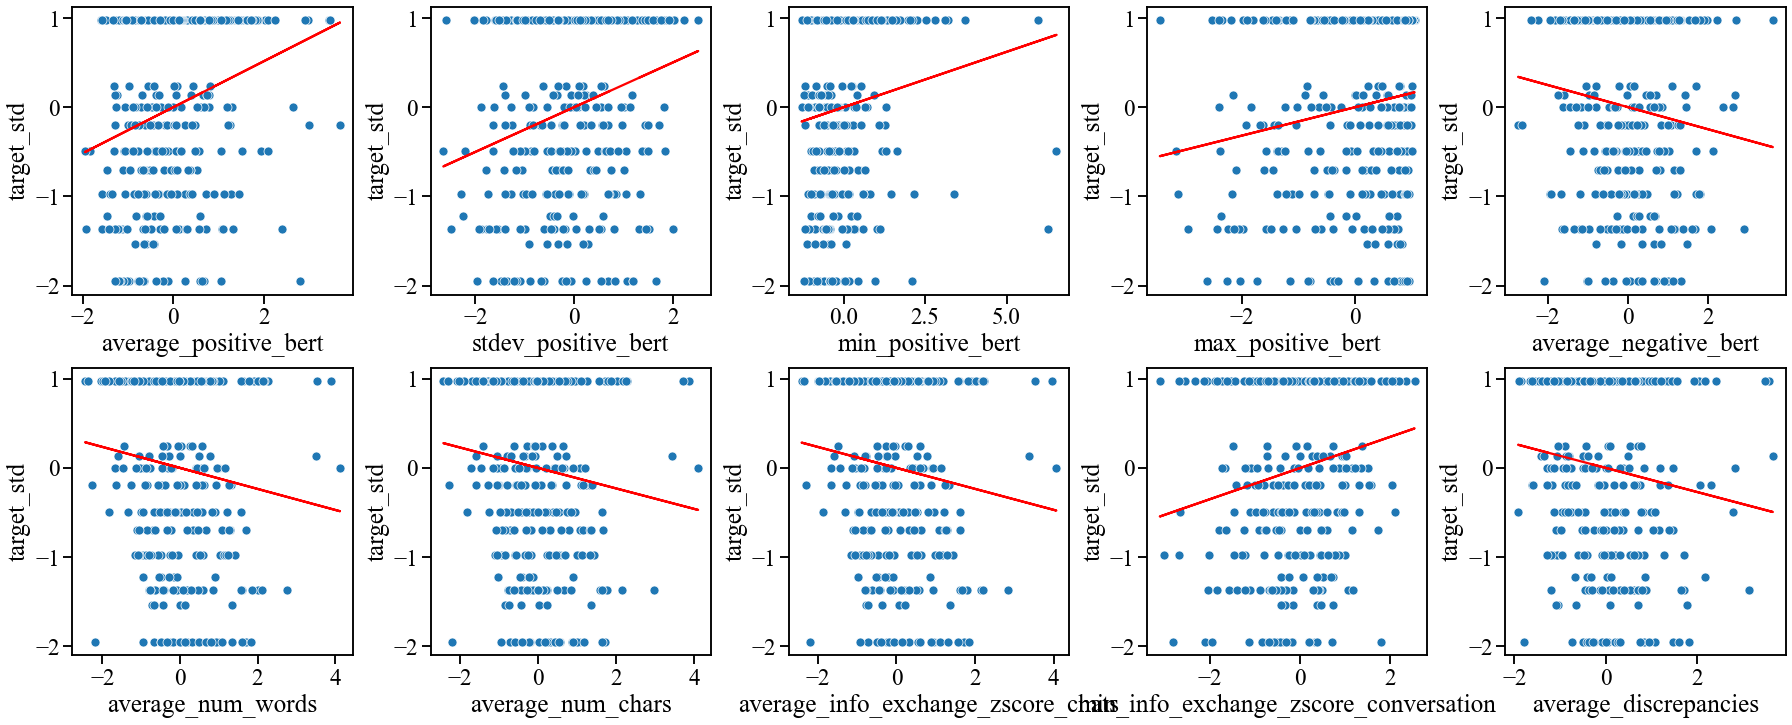

In [6]:
r2_jury_simple_models = plot_single_linear_model(juries_model.conv, juries_model.conv.drop(["target_raw", "target_std"], axis = 1), ["target_std"], num_top_plots=10)

In [7]:
r2_jury_simple_models

,x_var,y_var,r_squared,mse,mae
0,average_positive_bert,target_std,0.067130,0.930190,0.835298
58,average_positivity_zscore_chats,target_std,0.067130,0.930190,0.835298
63,max_positivity_zscore_conversation,target_std,0.064660,0.932652,0.841709
59,stdev_positivity_zscore_chats,target_std,0.063032,0.934276,0.838063
1,stdev_positive_bert,target_std,0.063032,0.934276,0.838063
90,average_user_num_chars,target_std,0.053624,0.943657,0.850660
86,average_user_num_words,target_std,0.052279,0.944998,0.851414
93,max_user_num_chars,target_std,0.037811,0.959424,0.862984
75,average_1st_person_pl.,target_std,0.035360,0.961868,0.859994
65,average_hashedge,target_std,0.035327,0.961901,0.861448


### 75% of Data

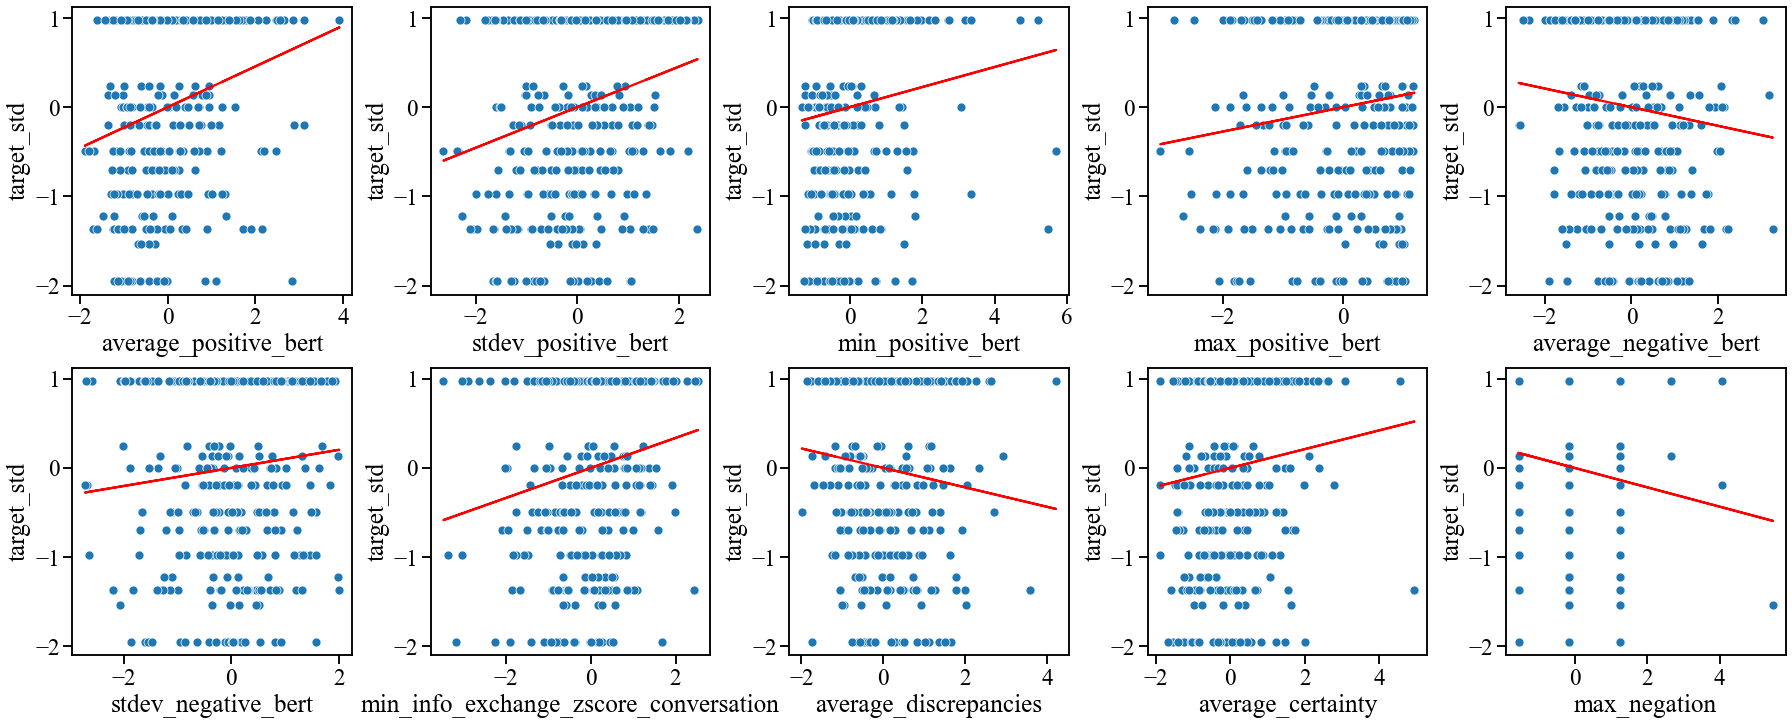

,x_var,y_var,r_squared,mse,mae
61,average_user_num_chars,target_std,0.053624,0.943657,0.850660
0,average_positive_bert,target_std,0.052427,0.944850,0.847795
32,average_positivity_zscore_chats,target_std,0.052427,0.944850,0.847795
57,average_user_num_words,target_std,0.052279,0.944998,0.851414
1,stdev_positive_bert,target_std,0.052007,0.945269,0.848429
33,stdev_positivity_zscore_chats,target_std,0.052007,0.945269,0.848429
64,max_user_num_chars,target_std,0.037811,0.959424,0.862984
37,max_positivity_zscore_conversation,target_std,0.037122,0.960111,0.858816
60,max_user_num_words,target_std,0.034950,0.962277,0.864949
40,stdev_hashedge,target_std,0.029950,0.967262,0.864664


In [8]:
juries_model75 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_75/')
juries_model75.select_target(target=["majority_pct"])
juries_model75.define_model(model_type = 'rf')

r2_jury_simple_models75 = plot_single_linear_model(juries_model75.conv, juries_model75.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)
r2_jury_simple_models75

### 50% Data

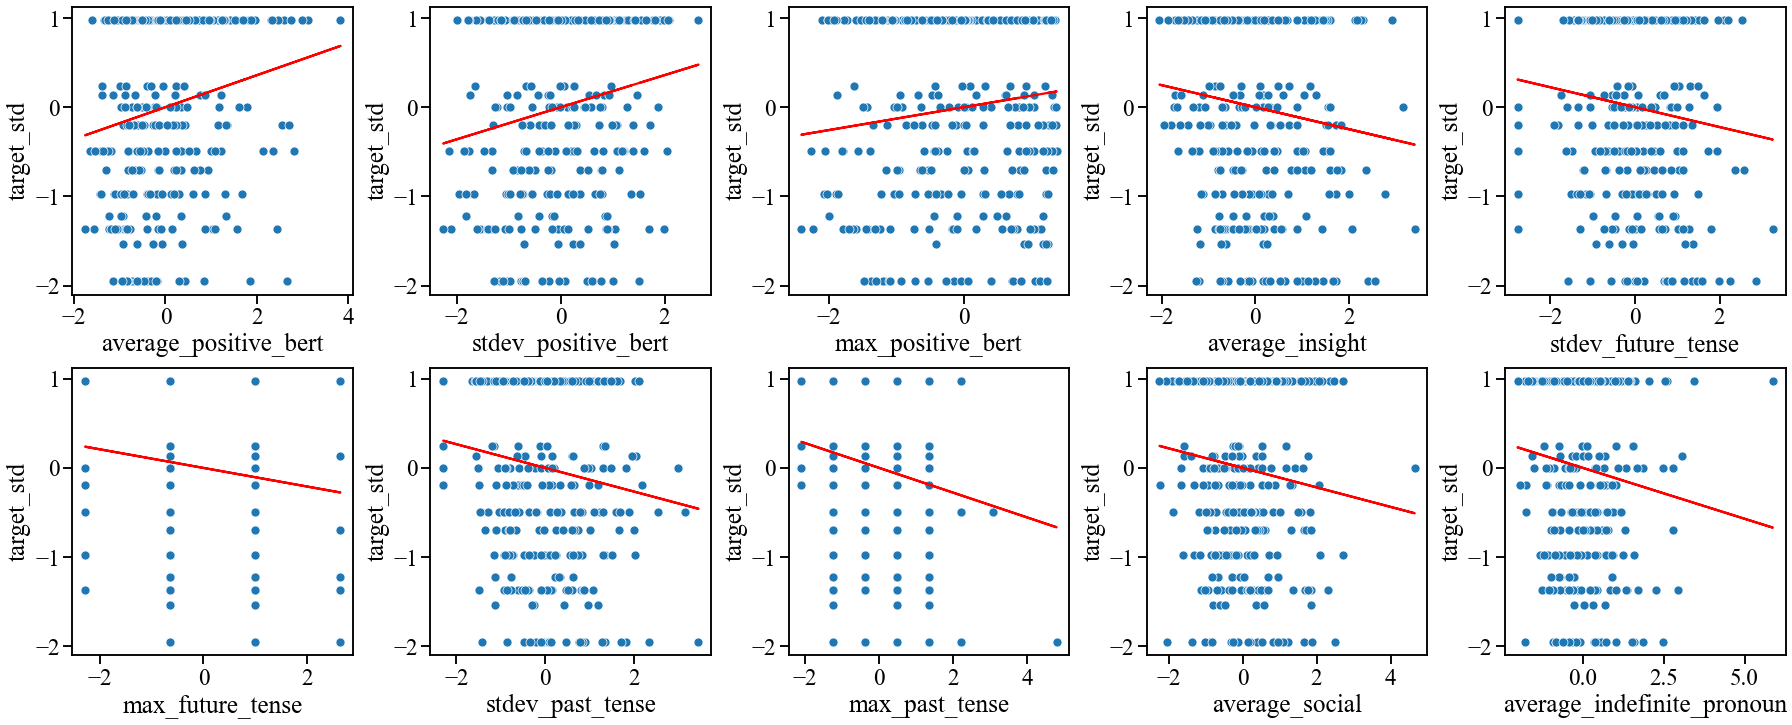

,x_var,y_var,r_squared,mse,mae
47,average_user_num_chars,target_std,0.053624,0.943657,0.850660
43,average_user_num_words,target_std,0.052279,0.944998,0.851414
50,max_user_num_chars,target_std,0.037811,0.959424,0.862984
46,max_user_num_words,target_std,0.034950,0.962277,0.864949
27,stdev_positivity_zscore_chats,target_std,0.032310,0.964909,0.859770
1,stdev_positive_bert,target_std,0.032310,0.964909,0.859770
26,average_positivity_zscore_chats,target_std,0.032249,0.964971,0.859762
0,average_positive_bert,target_std,0.032249,0.964971,0.859762
29,min_positivity_zscore_conversation,target_std,0.030493,0.966722,0.863242
32,stdev_hashedge,target_std,0.029364,0.967847,0.863944


In [9]:
juries_model50 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_50/')
juries_model50.select_target(target=["majority_pct"])
juries_model50.define_model(model_type = 'rf')

r2_jury_simple_models50 = plot_single_linear_model(juries_model50.conv, juries_model50.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)
r2_jury_simple_models50

### 25% of Data

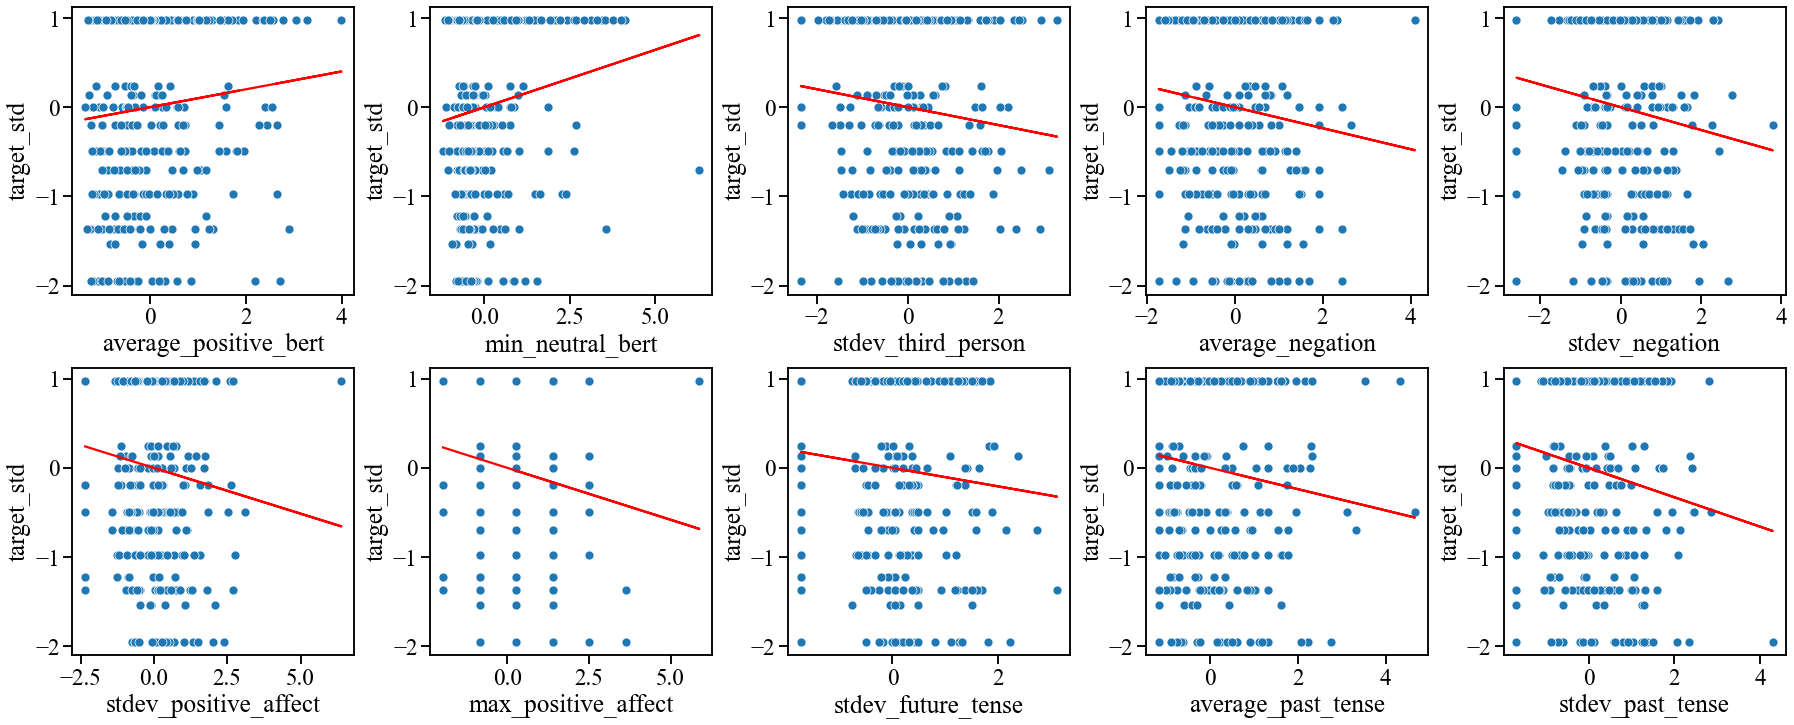

,x_var,y_var,r_squared,mse,mae
28,average_user_num_chars,target_std,0.053624,0.943657,0.850660
24,average_user_num_words,target_std,0.052279,0.944998,0.851414
31,max_user_num_chars,target_std,0.037811,0.959424,0.862984
27,max_user_num_words,target_std,0.034950,0.962277,0.864949
10,max_past_tense,target_std,0.032284,0.964935,0.867411
18,min_positivity_zscore_conversation,target_std,0.028689,0.968520,0.864251
9,stdev_past_tense,target_std,0.027112,0.970092,0.868042
30,min_user_num_chars,target_std,0.023354,0.973840,0.867040
26,min_user_num_words,target_std,0.023189,0.974004,0.868080
21,average_haspositive,target_std,0.019568,0.977614,0.875739


In [10]:
juries_model25 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_25/')
juries_model25.select_target(target=["majority_pct"])
juries_model25.define_model(model_type = 'rf')

r2_jury_simple_models25 = plot_single_linear_model(juries_model25.conv, juries_model25.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)
r2_jury_simple_models25

# CSOP (blended)

### Full Data (100%)

In [11]:
csop_blended_model = ModelBuilder(dataset_names = ["csop", "csopII"])
csop_blended_model.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model.define_model(model_type = 'rf')

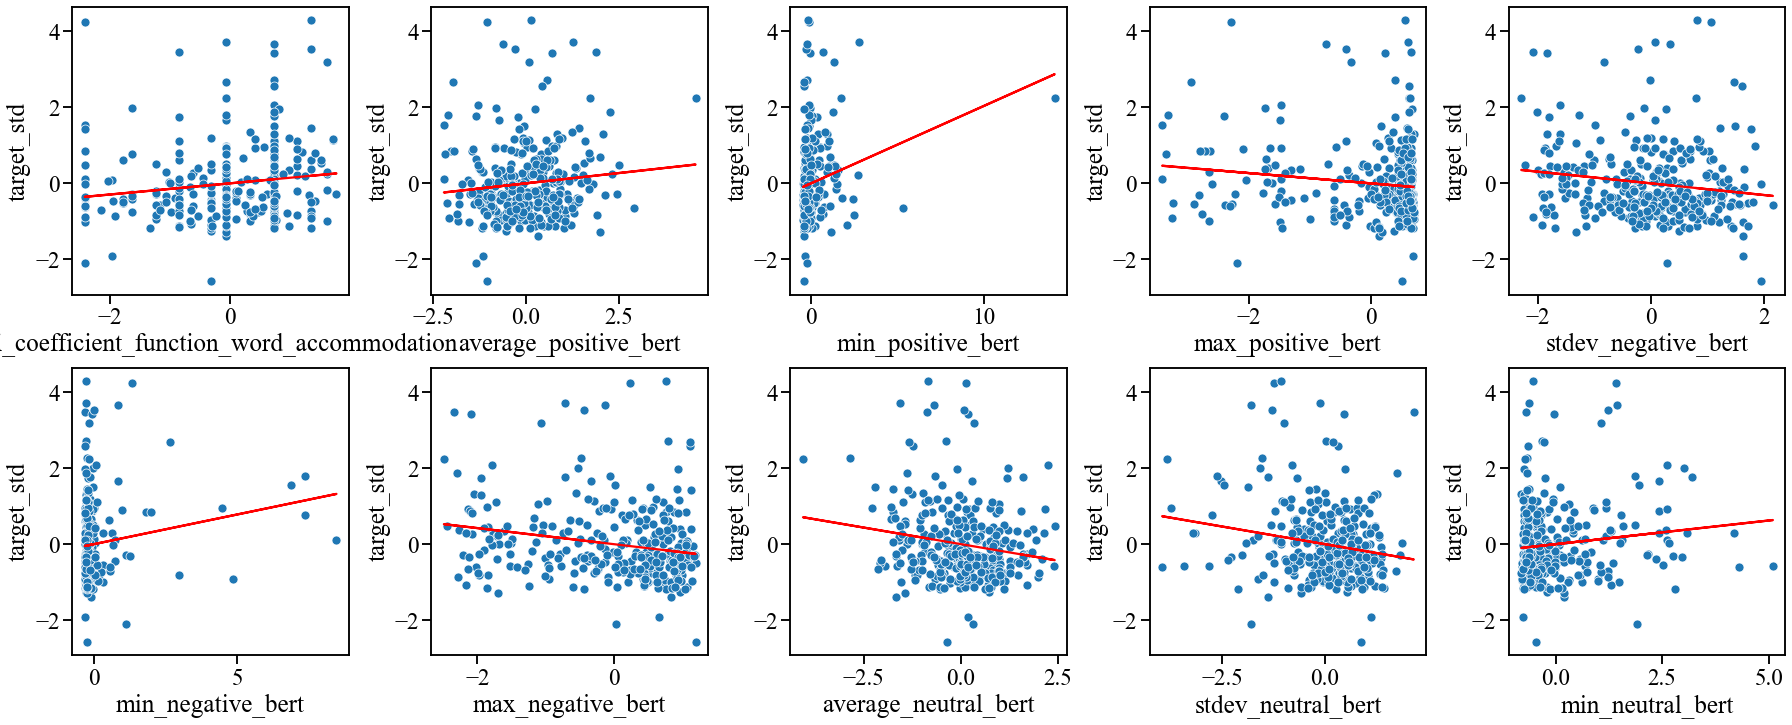

In [12]:
r2_csop_simple_models = plot_single_linear_model(csop_blended_model.conv, csop_blended_model.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)

In [13]:
r2_csop_simple_models

,x_var,y_var,r_squared,mse,mae
158,average_user_num_words,target_std,0.127710,0.872290,0.686919
162,average_user_num_chars,target_std,0.125189,0.874811,0.689229
161,max_user_num_words,target_std,0.114137,0.885863,0.691871
154,sum_num_words,target_std,0.111172,0.888828,0.694514
141,max_1st_person,target_std,0.108685,0.891315,0.696826
165,max_user_num_chars,target_std,0.107548,0.892452,0.694932
155,sum_num_chars,target_std,0.107117,0.892883,0.695453
166,average_user_num_messages,target_std,0.099053,0.900947,0.695213
39,max_negation,target_std,0.096671,0.903329,0.688070
169,max_user_num_messages,target_std,0.086741,0.913259,0.697366


### 75% Data

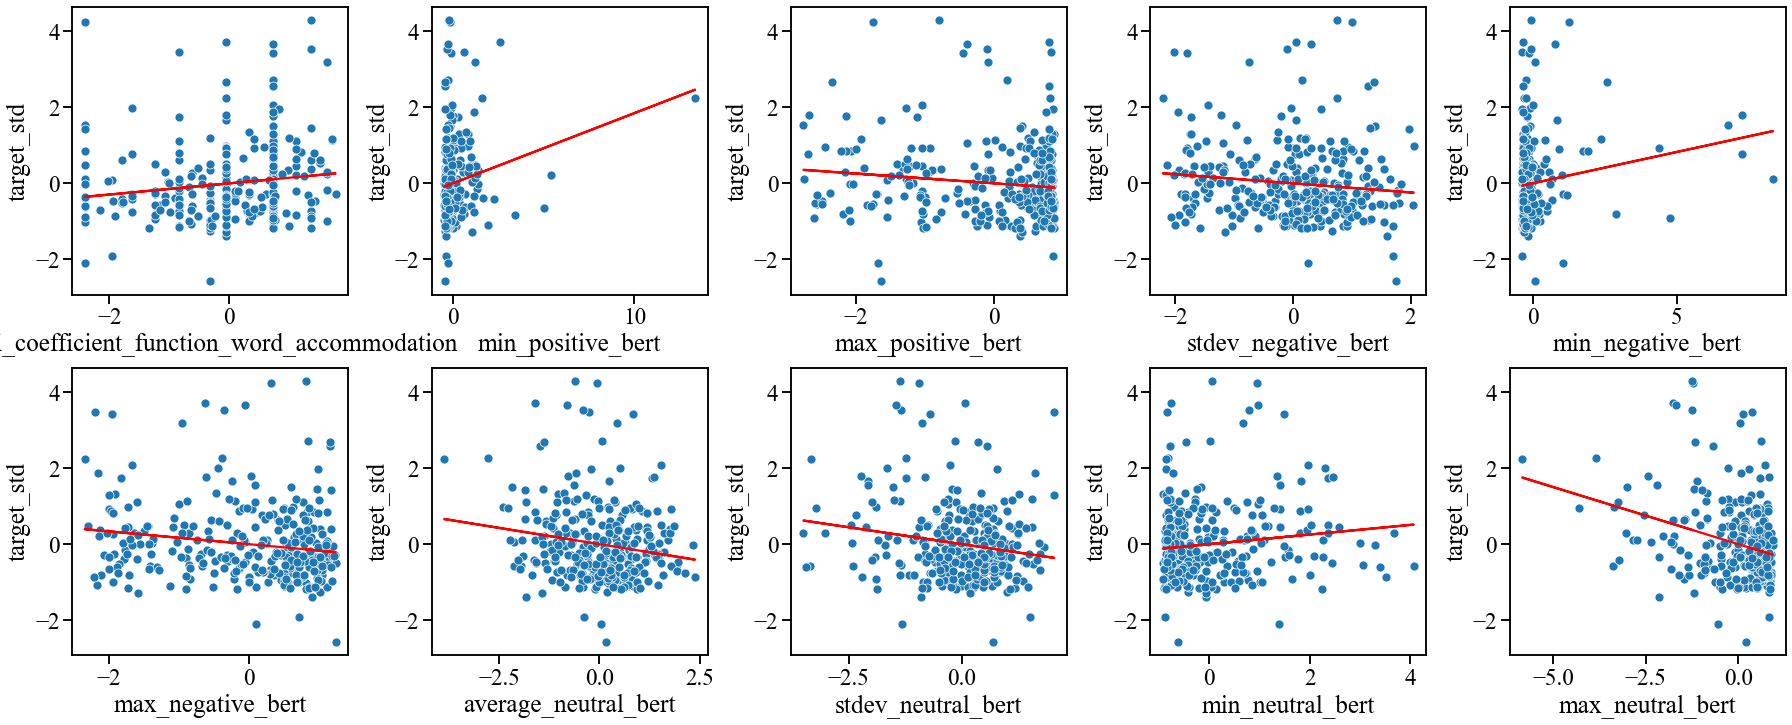

,x_var,y_var,r_squared,mse,mae
141,average_user_num_words,target_std,0.127710,0.872290,0.686919
145,average_user_num_chars,target_std,0.125189,0.874811,0.689229
144,max_user_num_words,target_std,0.114137,0.885863,0.691871
148,max_user_num_chars,target_std,0.107548,0.892452,0.694932
137,sum_num_words,target_std,0.104641,0.895359,0.696134
149,average_user_num_messages,target_std,0.099053,0.900947,0.695213
138,sum_num_chars,target_std,0.099019,0.900981,0.698068
9,max_neutral_bert,target_std,0.090531,0.909469,0.694347
152,max_user_num_messages,target_std,0.086741,0.913259,0.697366
126,max_1st_person,target_std,0.084961,0.915039,0.708009


In [14]:
csop_blended_model75 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_75/')
csop_blended_model75.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model75.define_model(model_type = 'rf')

r2_csop_simple_models75 = plot_single_linear_model(csop_blended_model75.conv, csop_blended_model75.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)
r2_csop_simple_models75

### 50% Data

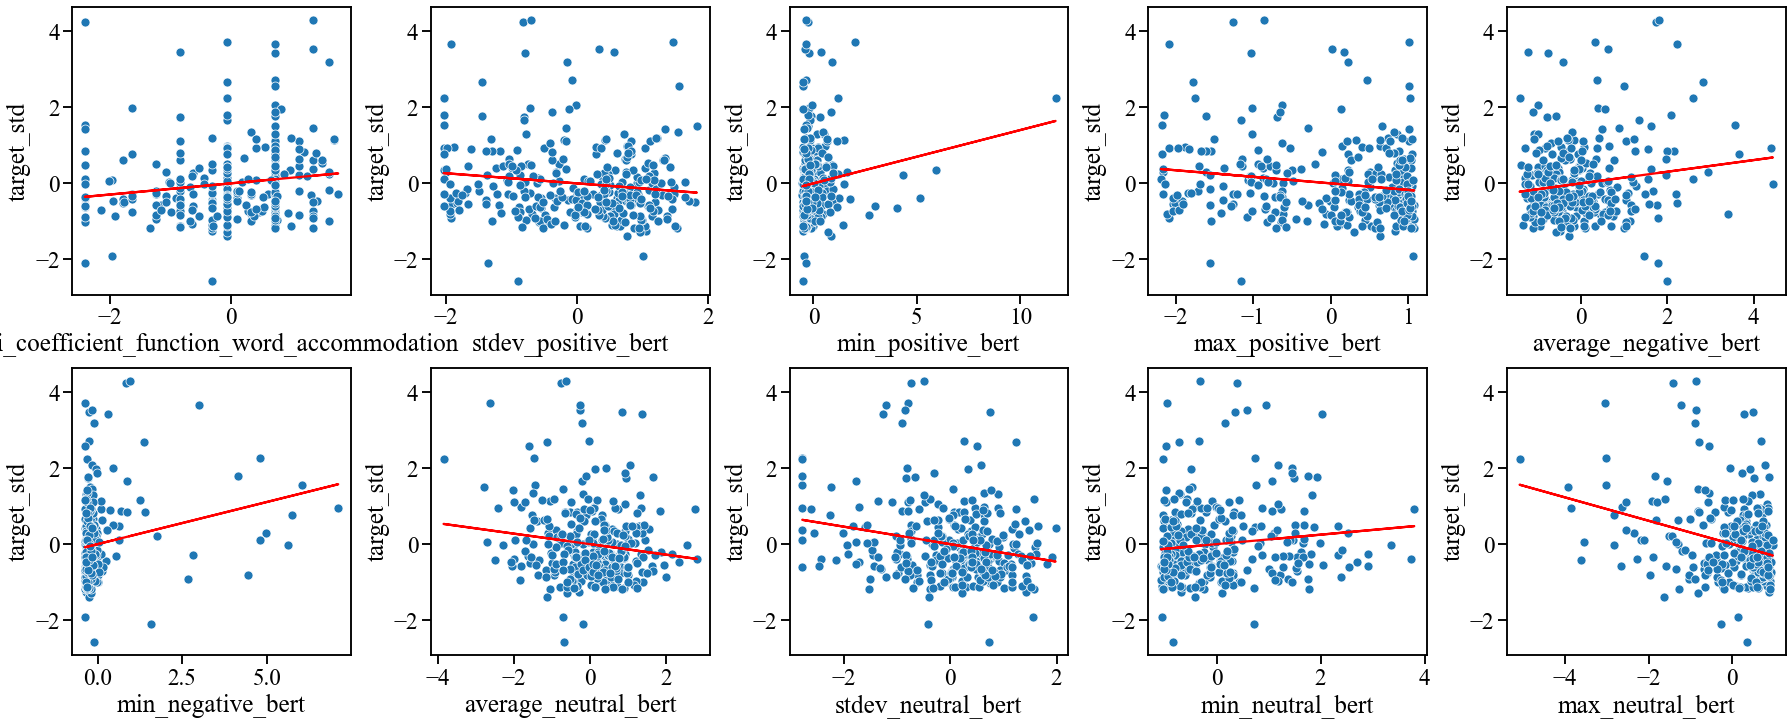

,x_var,y_var,r_squared,mse,mae
156,average_user_num_words,target_std,0.127710,0.872290,0.686919
160,average_user_num_chars,target_std,0.125189,0.874811,0.689229
159,max_user_num_words,target_std,0.114137,0.885863,0.691871
152,sum_num_words,target_std,0.107749,0.892251,0.691934
163,max_user_num_chars,target_std,0.107548,0.892452,0.694932
153,sum_num_chars,target_std,0.099148,0.900852,0.694552
164,average_user_num_messages,target_std,0.099053,0.900947,0.695213
9,max_neutral_bert,target_std,0.094503,0.905497,0.693050
167,max_user_num_messages,target_std,0.086741,0.913259,0.697366
172,within_person_disc_range,target_std,0.083304,0.916696,0.694264


In [15]:
csop_blended_model50 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_50/')
csop_blended_model50.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model50.define_model(model_type = 'rf')

r2_csop_simple_models50 = plot_single_linear_model(csop_blended_model50.conv, csop_blended_model50.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)
r2_csop_simple_models50

### 25% Data

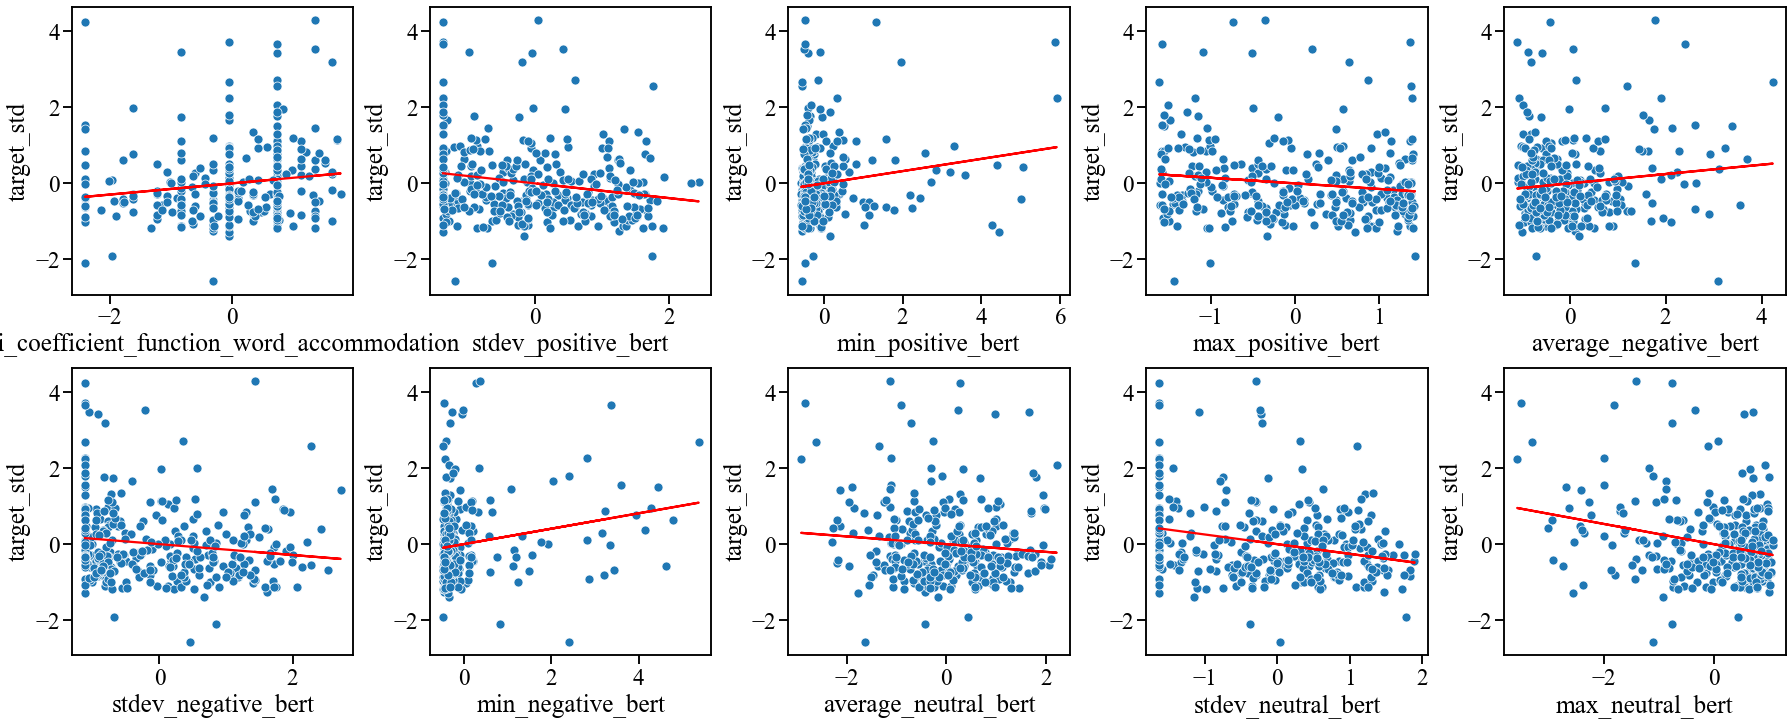

,x_var,y_var,r_squared,mse,mae
152,average_user_num_words,target_std,0.127710,0.872290,0.686919
156,average_user_num_chars,target_std,0.125189,0.874811,0.689229
155,max_user_num_words,target_std,0.114137,0.885863,0.691871
159,max_user_num_chars,target_std,0.107548,0.892452,0.694932
160,average_user_num_messages,target_std,0.099053,0.900947,0.695213
148,sum_num_words,target_std,0.095662,0.904338,0.697908
163,max_user_num_messages,target_std,0.086741,0.913259,0.697366
149,sum_num_chars,target_std,0.085727,0.914273,0.700989
150,sum_num_messages,target_std,0.082503,0.917497,0.699797
9,max_neutral_bert,target_std,0.070279,0.929721,0.702114


In [16]:
csop_blended_model25 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_25/')
csop_blended_model25.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model25.define_model(model_type = 'rf')

r2_csop_simple_models25 = plot_single_linear_model(csop_blended_model25.conv, csop_blended_model25.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)
r2_csop_simple_models25

# DAT

### Full data (100%)

In [17]:
dat_model = ModelBuilder(dataset_names = ["dat"])
dat_model.select_target(target=["efficiency"])
dat_model.define_model(model_type = 'rf')

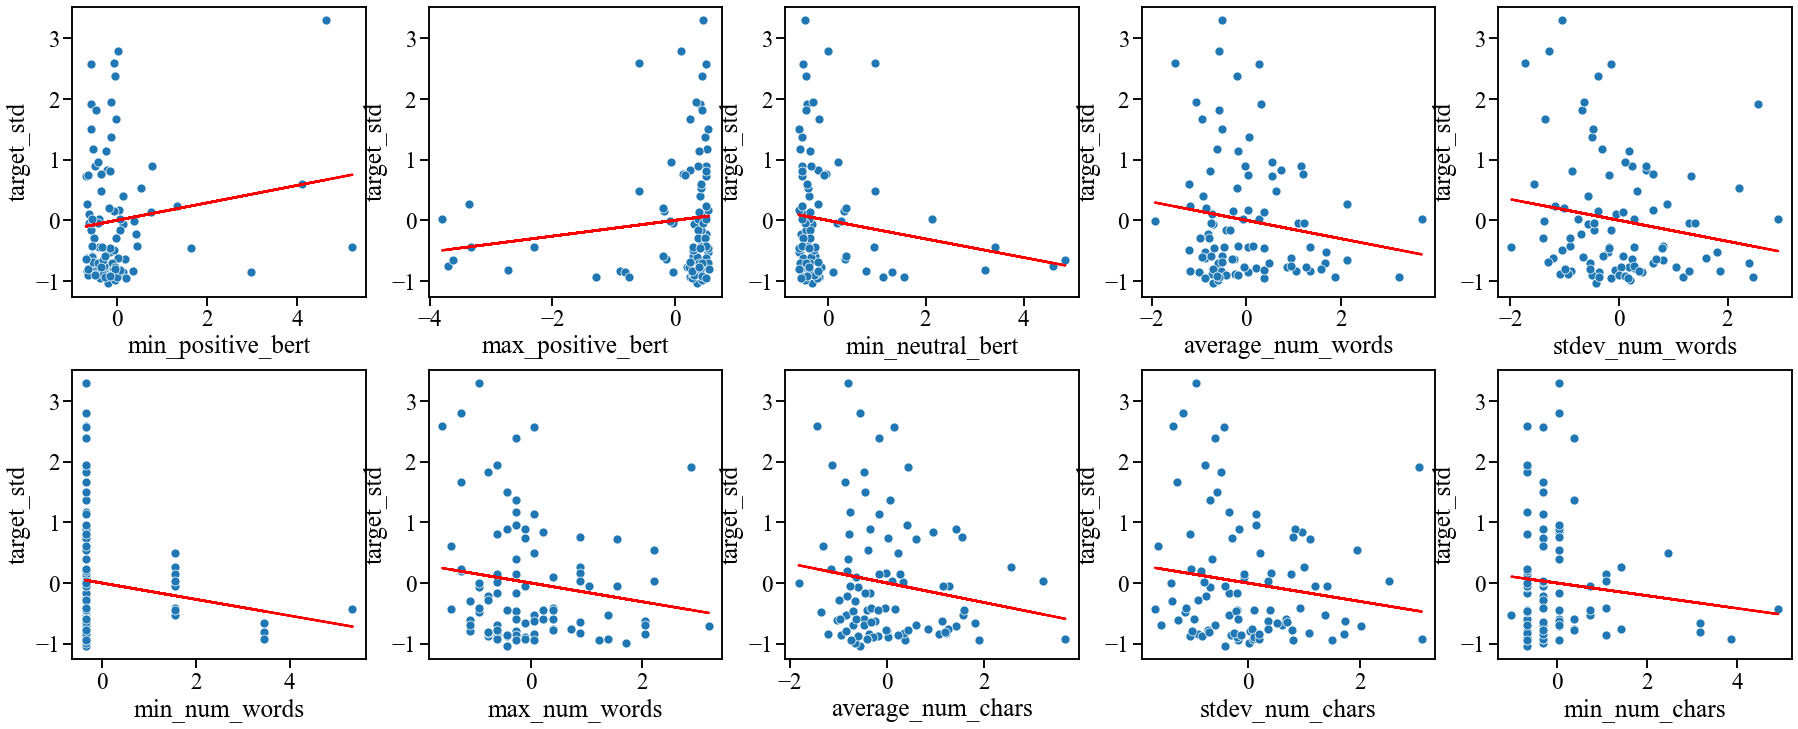

In [18]:
r2_dat_simple_models = plot_single_linear_model(dat_model.conv, dat_model.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots = 10)

In [19]:
r2_dat_simple_models

,x_var,y_var,r_squared,mse,mae
39,max_relative,target_std,0.079049,0.911048,0.730031
81,stdev_first_pronouns_proportion,target_std,0.061903,0.928010,0.744628
55,average_tentativeness,target_std,0.054459,0.935373,0.757234
85,average_textblob_polarity,target_std,0.054095,0.935734,0.777005
100,average_1st_person_start,target_std,0.054073,0.935756,0.763569
86,stdev_textblob_polarity,target_std,0.048431,0.941337,0.778887
65,average_preposition,target_std,0.045547,0.944190,0.766184
56,stdev_tentativeness,target_std,0.045423,0.944312,0.755996
37,average_relative,target_std,0.044379,0.945345,0.758104
38,stdev_relative,target_std,0.041888,0.947810,0.760439


### 75% Data

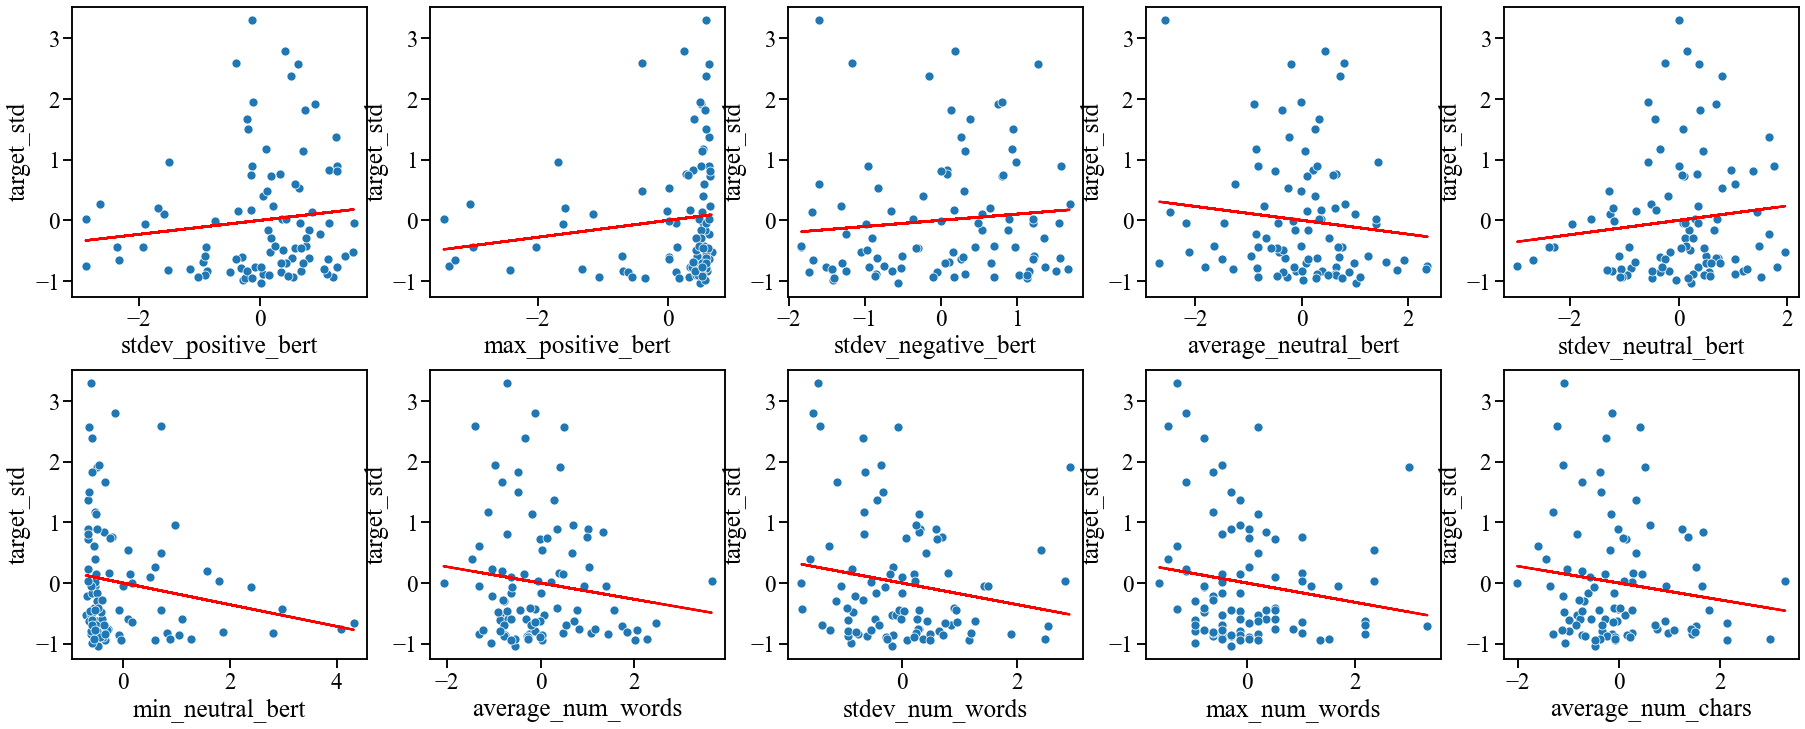

,x_var,y_var,r_squared,mse,mae
85,min_textblob_subjectivity,target_std,0.085871,0.904299,0.740795
110,average_1st_person_start,target_std,0.065315,0.924635,0.757107
81,stdev_first_pronouns_proportion,target_std,0.055486,0.934357,0.740835
38,max_relative,target_std,0.054775,0.935061,0.743924
111,stdev_1st_person_start,target_std,0.049546,0.940234,0.760721
36,average_relative,target_std,0.048416,0.941352,0.754789
82,max_first_pronouns_proportion,target_std,0.047979,0.941784,0.743479
37,stdev_relative,target_std,0.041808,0.947889,0.754589
55,average_tentativeness,target_std,0.039620,0.950053,0.767138
86,average_textblob_polarity,target_std,0.038630,0.951033,0.780873


In [20]:
dat_model75 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_75/')
dat_model75.select_target(target=["efficiency"])
dat_model75.define_model(model_type = 'rf')

r2_dat_simple_models75 = plot_single_linear_model(dat_model75.conv, dat_model75.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)
r2_dat_simple_models75

### 50% Data

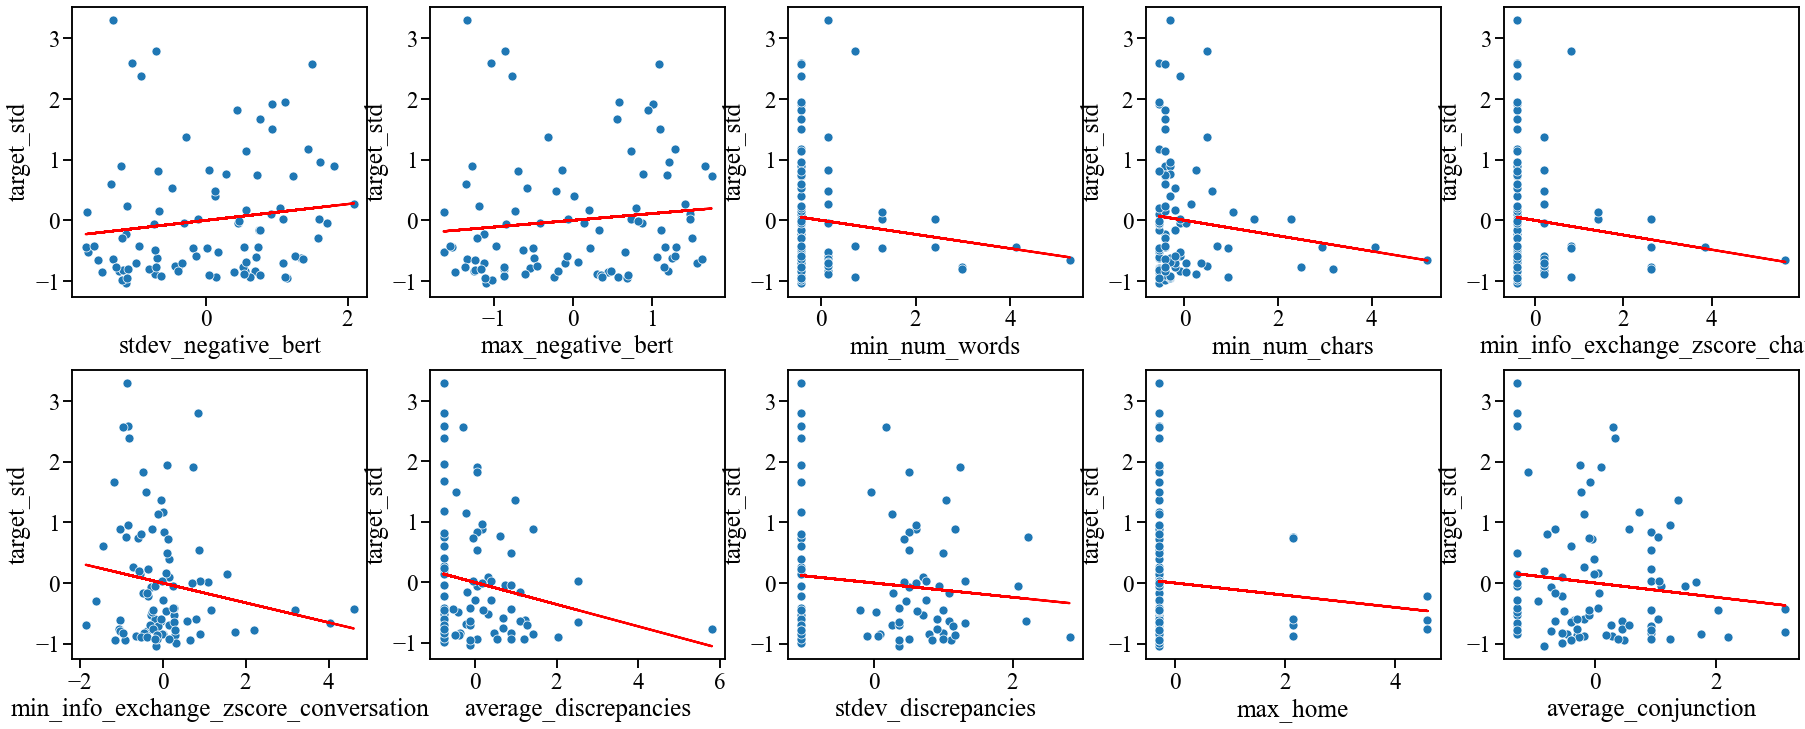

,x_var,y_var,r_squared,mse,mae
97,discursive_diversity,target_std,0.062788,0.927135,0.759499
88,average_user_num_chars,target_std,0.037400,0.952249,0.762505
84,average_user_num_words,target_std,0.037394,0.952255,0.762689
75,stdev_1st_person_start,target_std,0.037075,0.952571,0.758523
87,max_user_num_words,target_std,0.034867,0.954755,0.761178
91,max_user_num_chars,target_std,0.034771,0.954850,0.761945
40,stdev_first_person_singular,target_std,0.033819,0.955792,0.744901
28,average_relative,target_std,0.033613,0.955995,0.760053
6,average_discrepancies,target_std,0.033503,0.956105,0.765228
81,stdev_indirect_(greeting),target_std,0.031623,0.957965,0.758774


In [21]:
dat_model50 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_50/')
dat_model50.select_target(target=["efficiency"])
dat_model50.define_model(model_type = 'rf')

r2_dat_simple_models50 = plot_single_linear_model(dat_model50.conv, dat_model50.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)
r2_dat_simple_models50

### 25% Data

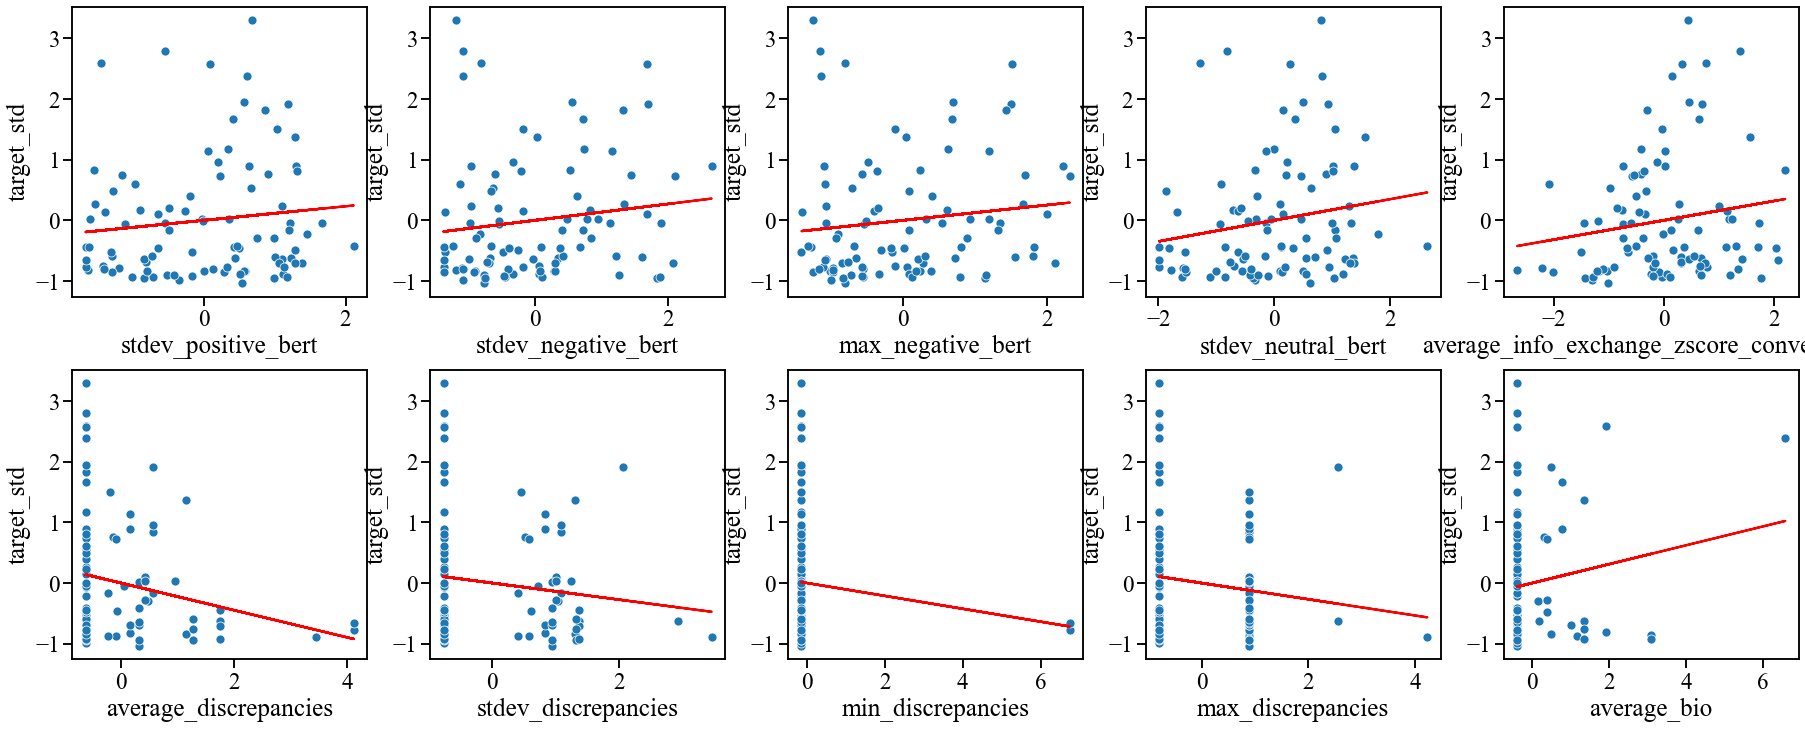

,x_var,y_var,r_squared,mse,mae
66,stdev_textblob_polarity,target_std,0.105845,0.884541,0.739297
67,max_textblob_polarity,target_std,0.096746,0.893541,0.758829
92,min_2nd_person,target_std,0.085871,0.904299,0.740795
54,min_second_person,target_std,0.085871,0.904299,0.740795
87,stdev_1st_person,target_std,0.064233,0.925705,0.742194
88,max_1st_person,target_std,0.063423,0.926506,0.740177
65,average_textblob_polarity,target_std,0.058982,0.930899,0.777161
62,average_textblob_subjectivity,target_std,0.058329,0.931546,0.772066
79,stdev_deference,target_std,0.052197,0.937612,0.765286
36,stdev_first_person_singular,target_std,0.051605,0.938197,0.761637


In [22]:
dat_model25 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_25/')
dat_model25.select_target(target=["efficiency"])
dat_model25.define_model(model_type = 'rf')

r2_dat_simple_models25 = plot_single_linear_model(dat_model25.conv, dat_model25.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)
r2_dat_simple_models25

# Estimation

### Full Data (100%)

In [23]:
estimation_blended_model = ModelBuilder(dataset_names = ["gurcay", "becker"])
estimation_blended_model.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model.define_model(model_type = 'rf')

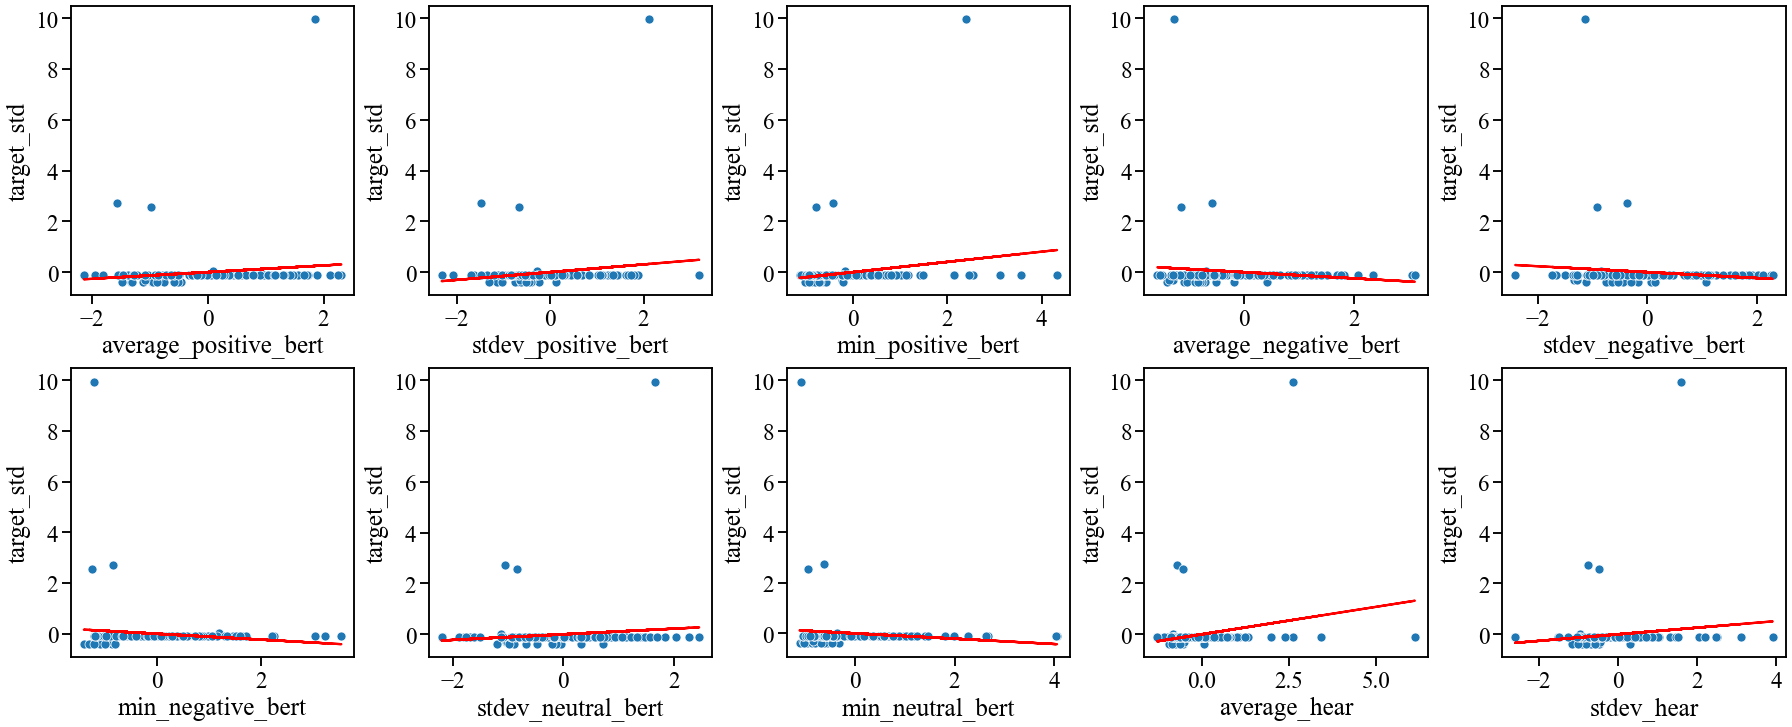

In [24]:
r2_estimation_simple_models = plot_single_linear_model(estimation_blended_model.conv, estimation_blended_model.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots = 10)

In [25]:
r2_estimation_simple_models

,x_var,y_var,r_squared,mse,mae
37,average_first_person_plural,target_std,0.117913,0.882087,0.371494
54,average_1st_person_pl.,target_std,0.087222,0.912778,0.344273
24,max_positive_affect,target_std,0.081069,0.918931,0.381622
31,stdev_friends,target_std,0.069140,0.930860,0.248251
38,stdev_first_person_plural,target_std,0.064362,0.935638,0.362457
30,average_friends,target_std,0.063446,0.936554,0.252117
32,max_friends,target_std,0.056876,0.943124,0.245931
8,average_hear,target_std,0.046969,0.953031,0.295274
50,stdev_dale_chall_score,target_std,0.046147,0.953853,0.322334
59,max_direct_question,target_std,0.045714,0.954286,0.256435


### 75% Data

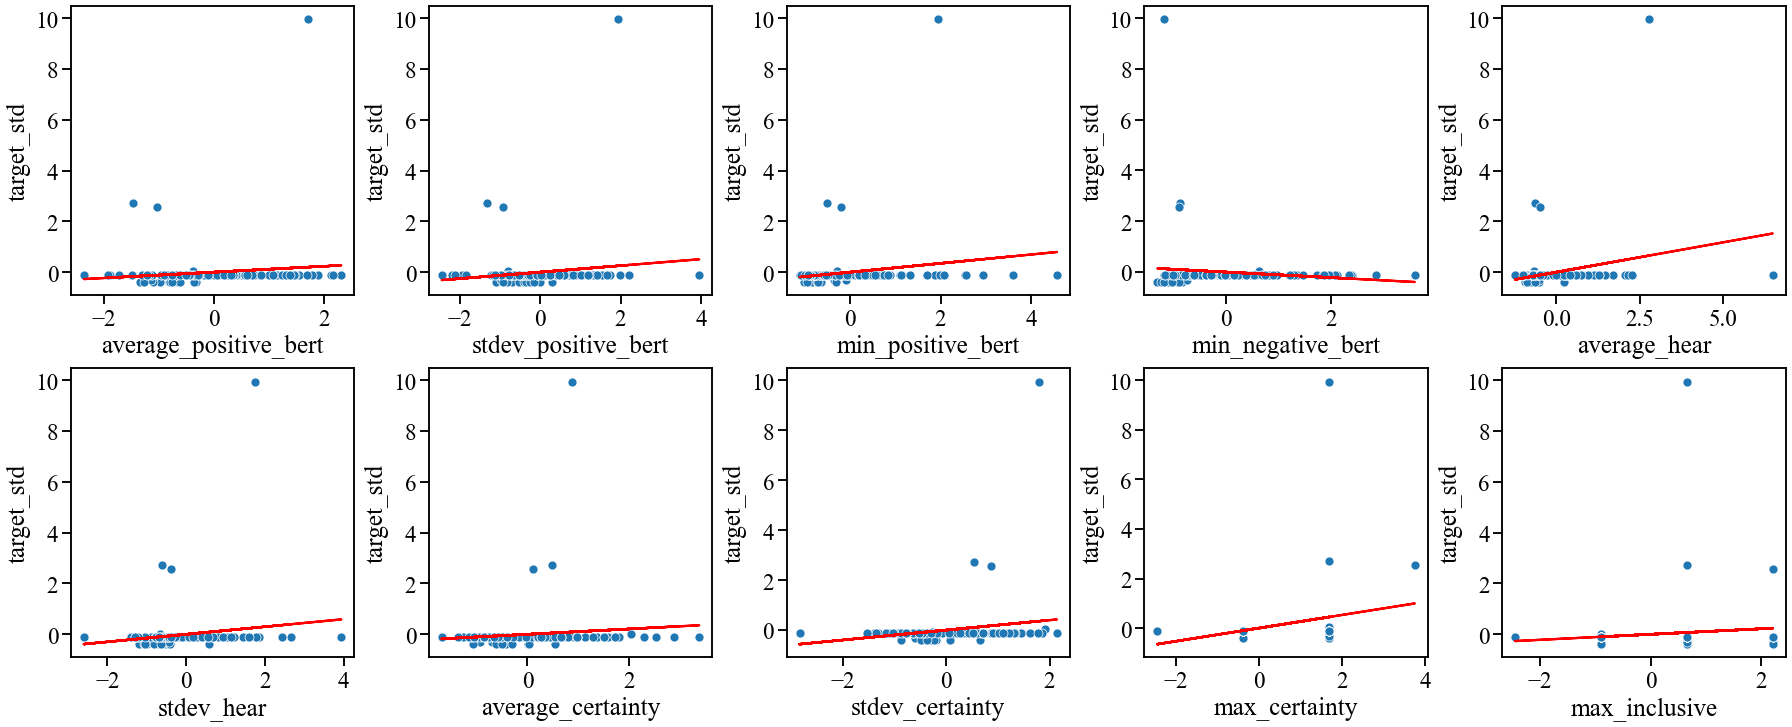

,x_var,y_var,r_squared,mse,mae
16,max_positive_affect,target_std,0.091054,0.908946,0.401536
8,max_certainty,target_std,0.070440,0.929560,0.267690
41,stdev_dale_chall_score,target_std,0.058596,0.941404,0.335603
4,average_hear,target_std,0.055133,0.944867,0.304604
29,average_first_person_plural,target_std,0.054009,0.945991,0.319534
42,max_dale_chall_score,target_std,0.053181,0.946819,0.324252
30,stdev_first_person_plural,target_std,0.047206,0.952794,0.357740
7,stdev_certainty,target_std,0.039551,0.960449,0.325874
32,average_percept,target_std,0.038883,0.961117,0.290279
43,average_1st_person_pl.,target_std,0.035640,0.964360,0.296296


In [26]:
estimation_blended_model75 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_75/')
estimation_blended_model75.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model75.define_model(model_type = 'rf')

r2_estimation_simple_models75 = plot_single_linear_model(estimation_blended_model75.conv, estimation_blended_model75.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)
r2_estimation_simple_models75

### 50% Data

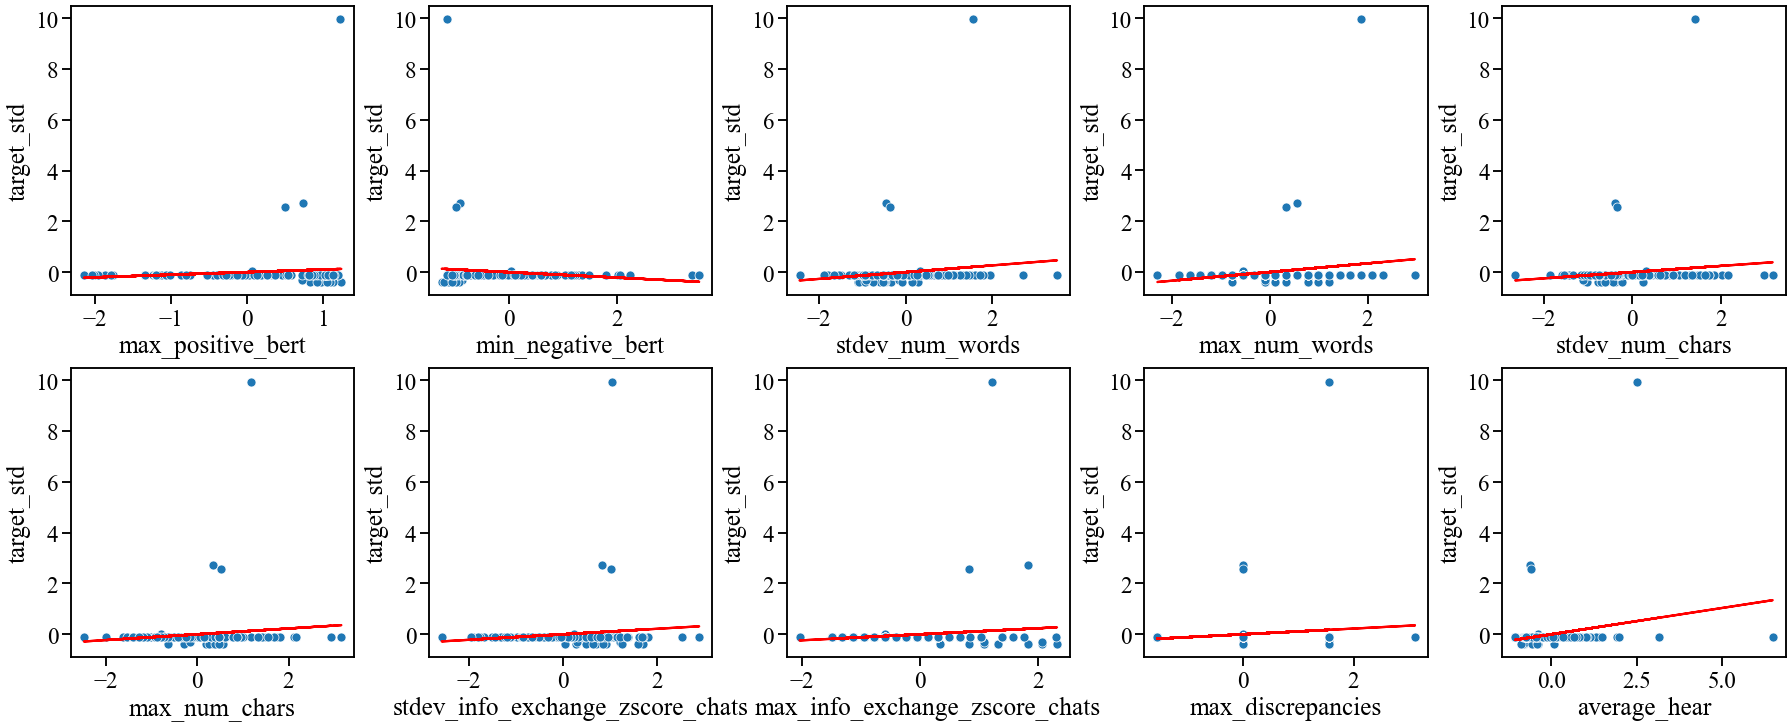

,x_var,y_var,r_squared,mse,mae
20,max_positive_affect,target_std,0.115600,0.884400,0.392942
33,average_first_person_plural,target_std,0.087864,0.912136,0.361620
46,stdev_dale_chall_score,target_std,0.075102,0.924898,0.354295
34,stdev_first_person_plural,target_std,0.071615,0.928385,0.379180
45,average_dale_chall_score,target_std,0.065694,0.934306,0.336460
13,max_certainty,target_std,0.060761,0.939239,0.337131
47,max_dale_chall_score,target_std,0.056383,0.943617,0.339961
50,average_1st_person_pl.,target_std,0.051644,0.948356,0.305429
32,max_cognitive_mech,target_std,0.048869,0.951131,0.327220
19,stdev_positive_affect,target_std,0.042872,0.957128,0.329381


In [27]:
estimation_blended_model50 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_50/')
estimation_blended_model50.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model50.define_model(model_type = 'rf')

r2_estimation_simple_models50 = plot_single_linear_model(estimation_blended_model50.conv, estimation_blended_model50.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)
r2_estimation_simple_models50

### 25% Data

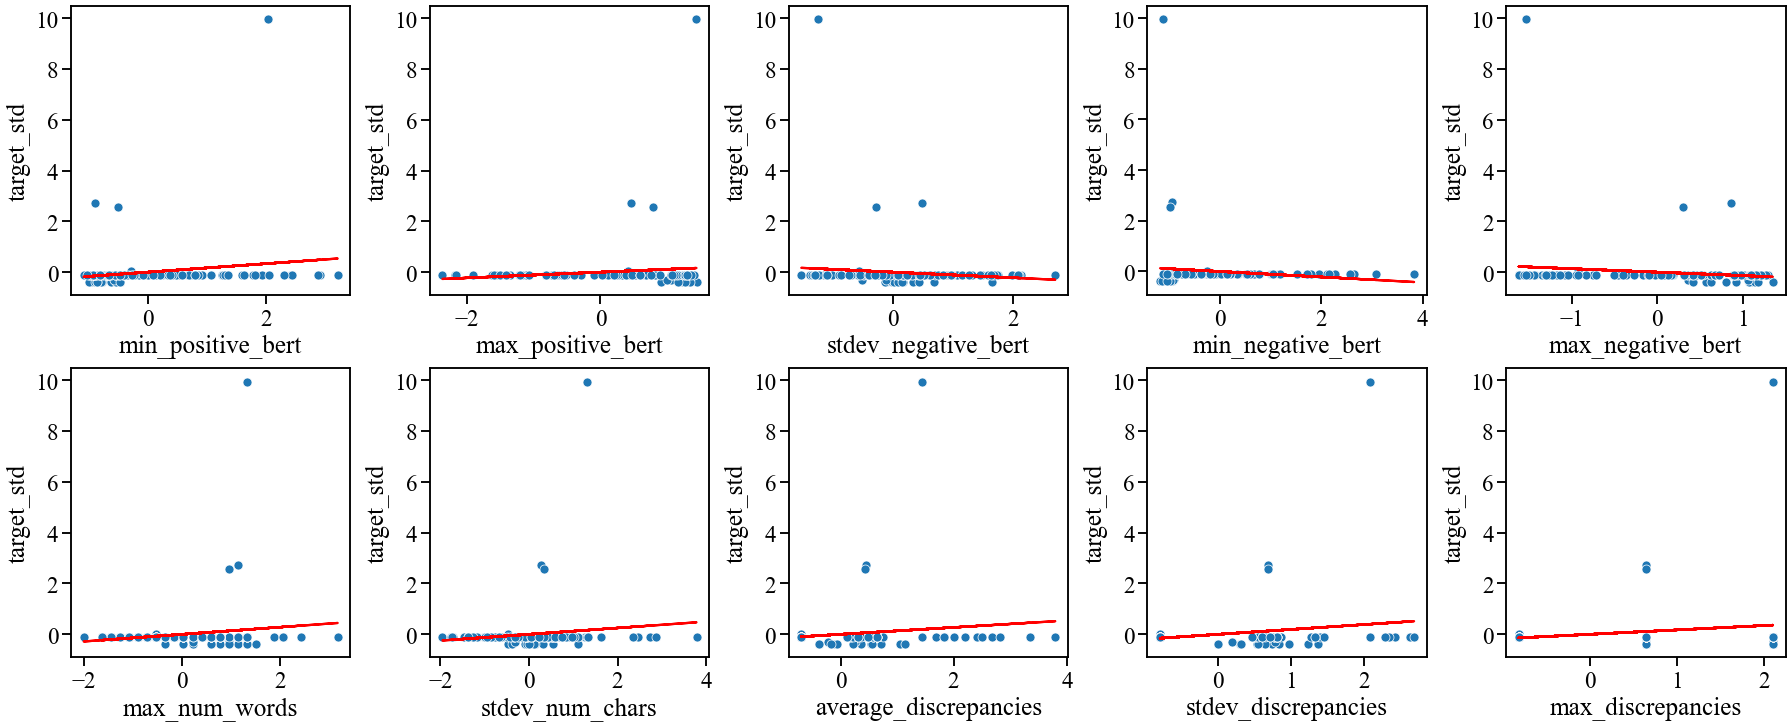

,x_var,y_var,r_squared,mse,mae
41,stdev_first_person_plural,target_std,0.151683,0.848317,0.369727
22,max_positive_affect,target_std,0.136319,0.863681,0.395889
42,max_first_person_plural,target_std,0.124055,0.875945,0.368275
40,average_first_person_plural,target_std,0.104961,0.895039,0.289022
21,stdev_positive_affect,target_std,0.087001,0.912999,0.392525
61,stdev_dale_chall_score,target_std,0.072966,0.927034,0.299192
13,max_certainty,target_std,0.069871,0.930129,0.387812
36,max_cognitive_mech,target_std,0.064974,0.935026,0.342953
65,max_hedges,target_std,0.060802,0.939198,0.261032
62,max_dale_chall_score,target_std,0.059014,0.940986,0.297838


In [28]:
estimation_blended_model25 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_25/')
estimation_blended_model25.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model25.define_model(model_type = 'rf')

r2_estimation_simple_models25 = plot_single_linear_model(estimation_blended_model25.conv, estimation_blended_model25.conv.drop(["target_raw", "target_std"], axis=1), ["target_std"], num_top_plots=10)
r2_estimation_simple_models25